# Phase 3 Data Science Training Notebook

In [19]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime
from  matplotlib import pyplot as plt

## Exploratory Data Analysis

In [20]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [21]:
def get_image(cifar_data):
    image=cifar_data.reshape(3, 32, 32) / 255
    return np.swapaxes(np.swapaxes(image, 0, 1), 1, 2)

In [22]:
batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
batch_5 = unpickle('cifar-10-batches-py/data_batch_5')

all_labels = np.concatenate((batch_1[b'labels'], batch_2[b'labels'], batch_3[b'labels'], batch_4[b'labels'], batch_5[b'labels']), axis=0)
all_data = np.concatenate((batch_1[b'data'], batch_2[b'data'], batch_3[b'data'], batch_4[b'data'], batch_5[b'data']), axis=0)

test_batch = unpickle('cifar-10-batches-py/test_batch')
test_batch_labels = np.array(test_batch[b'labels'])
test_batch_data = np.array(test_batch[b'data'])


In [23]:
print('The shape of the all batch data: ', all_data.shape)
print('The shape of the test batch data: ', test_batch_data.shape)

The shape of the all batch data:  (50000, 3072)
The shape of the test batch data:  (10000, 3072)


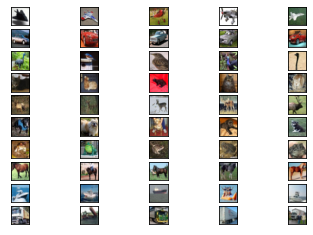

In [24]:
f=plt.figure()
for i in range(10):
    count = 0
    for j in range(len(all_labels)):
        if all_labels[j] == i:
            f.add_subplot(10, 5, 5 * i + count + 1)
            plt.imshow(get_image(all_data[j]))
            plt.xticks([])
            plt.yticks([])
            count += 1
            if count == 5:
                break

In [25]:
# I choose label bird (2) for probability that the item/animal is there

# Data Processing

In [26]:
train_labels = np.array([])
train_data = None
for i in range(10):
    count = 0
    for j in range(len(all_labels)):
        if all_labels[j] == i:
            if train_data is None:
                train_data = all_data[j].reshape(1, -1)
            else:
                train_data = np.append(train_data, all_data[j].reshape(1, -1), axis=0)
            count += 1
            if i == 2:
                train_labels = np.append(train_labels, 1)
                if count == 5000:
                    break
            elif i < 6:
                train_labels = np.append(train_labels, 0)
                if count == 556:
                    break
            else:
                train_labels = np.append(train_labels, 0)
                if count == 555:
                    break
train_data = np.swapaxes(np.swapaxes(train_data.reshape(train_data.shape[0], 3, 32, 32), 1, 2), 2, 3)

test_labels = np.array([])
test_data = None
for i in range(10):
    count = 0
    for j in range(len(test_batch_labels)):
        if test_batch_labels[j] == i:
            if test_data is None:
                test_data = test_batch_data[j].reshape(1, -1)
            else:
                test_data = np.append(test_data, test_batch_data[j].reshape(1, -1), axis=0)
            count += 1
            if i == 2:
                test_labels = np.append(test_labels, 1)
                if count == 1000:
                    break
            elif i == 0:
                test_labels = np.append(test_labels, 0)
                if count == 112:
                    break
            else:
                test_labels = np.append(test_labels, 0)
                if count == 111:
                    break
test_data = np.swapaxes(np.swapaxes(test_data.reshape(test_data.shape[0], 3, 32, 32), 1, 2), 2, 3)

print('The shape of the training set: ', train_data.shape)
print('The shape of the testing set: ', test_data.shape)

The shape of the training set:  (10000, 32, 32, 3)
The shape of the testing set:  (2000, 32, 32, 3)


In [27]:
train_x = train_data
train_y = train_labels
test_x = test_data
test_y = test_labels

labels = [0 for i in range(2)]
for label in train_labels:
    labels[int(label)] += 1
print('Number of images in each label in training set: ', labels)

labels = [0 for i in range(2)]
for label in test_labels:
    labels[int(label)] += 1
print('Number of images in each label in testing set: ', labels)

Number of images in each label in training set:  [5000, 5000]
Number of images in each label in testing set:  [1000, 1000]


# Data Modelling

In [28]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(32, 32, 3)))  # Input layer.

    # Example pre-processing layer.
    model.add(layers.Rescaling(scale=1./255, name="Normaliser"))

    model.add(layers.Conv2D(filters=32, kernel_size=3, strides=2,
                            input_shape=(32, 32, 3),
                            activation='relu',
                            padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=2,
                            activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))

    # Output layer.
    model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability"))

    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.01),
        loss=losses.BinaryCrossentropy(),
        # loss=losses.MeanAbsoluteError(),
        metrics=['accuracy']
    )

    return model


In [29]:
model = generateModel()

log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=50000,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    # verbose=0 # Uncomment this line to reduce the printing on console.
)

Epoch 1/50000
10/10 [==============================] - 2s 167ms/step - loss: 0.7717 - accuracy: 0.5414 - val_loss: 0.6926 - val_accuracy: 0.5065
Epoch 2/50000
10/10 [==============================] - 2s 154ms/step - loss: 0.7054 - accuracy: 0.5748 - val_loss: 0.6918 - val_accuracy: 0.5405
Epoch 3/50000
10/10 [==============================] - 2s 154ms/step - loss: 0.6718 - accuracy: 0.6139 - val_loss: 0.6917 - val_accuracy: 0.5560
Epoch 4/50000
10/10 [==============================] - 2s 164ms/step - loss: 0.6634 - accuracy: 0.6169 - val_loss: 0.6918 - val_accuracy: 0.5575
Epoch 5/50000
10/10 [==============================] - 2s 170ms/step - loss: 0.6464 - accuracy: 0.6391 - val_loss: 0.6924 - val_accuracy: 0.5340
Epoch 6/50000
10/10 [==============================] - 2s 181ms/step - loss: 0.6382 - accuracy: 0.6457 - val_loss: 0.6931 - val_accuracy: 0.5155
Epoch 7/50000
10/10 [==============================] - 2s 188ms/step - loss: 0.6288 - accuracy: 0.6571 - val_loss: 0.6934 - val_ac

In [30]:
model.save('output/my_model')

INFO:tensorflow:Assets written to: output/my_model\assets


INFO:tensorflow:Assets written to: output/my_model\assets
